# FX intraday volatility
Clean notebook version for the project.  
This copy keeps code and removes any class references.


In [152]:
# Imports
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from typing import Dict

In [112]:
# Load raw data
order_path = "/Users/Mel/Desktop/Berkeley/230X/HW1/data/currency_bcourses/ORDER CURRENCY.csv"
trade_path = "/Users/Mel/Desktop/Berkeley/230X/HW1/data/currency_bcourses/TRADE CURRENCY.csv"
orders_raw = pd.read_csv(order_path)
trades_raw = pd.read_csv(trade_path)

In [113]:
trades_raw.columns

Index(['Index', 'Time', 'EBS_BOOK::EUR/USD.BUY_SELL_FLAG',
       'EBS_BOOK::EUR/USD.NUM_PARTCP', 'EBS_BOOK::EUR/USD.PRICE',
       'EBS_BOOK::EUR/USD.SIZE', 'EBS_BOOK::EUR/USD.TOTAL_SIZE',
       'EBS_BOOK::EUR/USD.OMDSEQ', 'EBS_BOOK::USD/JPY.BUY_SELL_FLAG',
       'EBS_BOOK::USD/JPY.NUM_PARTCP', 'EBS_BOOK::USD/JPY.PRICE',
       'EBS_BOOK::USD/JPY.SIZE', 'EBS_BOOK::USD/JPY.TOTAL_SIZE',
       'EBS_BOOK::USD/JPY.OMDSEQ', 'EBS_BOOK::EUR/JPY.BUY_SELL_FLAG',
       'EBS_BOOK::EUR/JPY.NUM_PARTCP', 'EBS_BOOK::EUR/JPY.PRICE',
       'EBS_BOOK::EUR/JPY.SIZE', 'EBS_BOOK::EUR/JPY.TOTAL_SIZE',
       'EBS_BOOK::EUR/JPY.OMDSEQ'],
      dtype='object')

In [114]:
orders_raw.columns

Index(['Index', 'Time', 'EBS_BOOK::EUR/JPY.DELETED_TIME',
       'EBS_BOOK::EUR/JPY.NUM_PARTCP', 'EBS_BOOK::EUR/JPY.BUY_SELL_FLAG',
       'EBS_BOOK::EUR/JPY.TICK_STATUS', 'EBS_BOOK::EUR/JPY.RECORD_TYPE',
       'EBS_BOOK::EUR/JPY.PRICE', 'EBS_BOOK::EUR/JPY.SIZE',
       'EBS_BOOK::EUR/JPY.OMDSEQ', 'EBS_BOOK::EUR/USD.DELETED_TIME',
       'EBS_BOOK::EUR/USD.NUM_PARTCP', 'EBS_BOOK::EUR/USD.BUY_SELL_FLAG',
       'EBS_BOOK::EUR/USD.TICK_STATUS', 'EBS_BOOK::EUR/USD.RECORD_TYPE',
       'EBS_BOOK::EUR/USD.PRICE', 'EBS_BOOK::EUR/USD.SIZE',
       'EBS_BOOK::EUR/USD.OMDSEQ', 'EBS_BOOK::USD/JPY.DELETED_TIME',
       'EBS_BOOK::USD/JPY.NUM_PARTCP', 'EBS_BOOK::USD/JPY.BUY_SELL_FLAG',
       'EBS_BOOK::USD/JPY.TICK_STATUS', 'EBS_BOOK::USD/JPY.RECORD_TYPE',
       'EBS_BOOK::USD/JPY.PRICE', 'EBS_BOOK::USD/JPY.SIZE',
       'EBS_BOOK::USD/JPY.OMDSEQ'],
      dtype='object')

In [115]:
orders_raw

,Index,Time,EBS_BOOK::EUR/JPY.DELETED_TIME,EBS_BOOK::EUR/JPY.NUM_PARTCP,EBS_BOOK::EUR/JPY.BUY_SELL_FLAG,EBS_BOOK::EUR/JPY.TICK_STATUS,EBS_BOOK::EUR/JPY.RECORD_TYPE,EBS_BOOK::EUR/JPY.PRICE,EBS_BOOK::EUR/JPY.SIZE,EBS_BOOK::EUR/JPY.OMDSEQ,...,EBS_BOOK::EUR/USD.SIZE,EBS_BOOK::EUR/USD.OMDSEQ,EBS_BOOK::USD/JPY.DELETED_TIME,EBS_BOOK::USD/JPY.NUM_PARTCP,EBS_BOOK::USD/JPY.BUY_SELL_FLAG,EBS_BOOK::USD/JPY.TICK_STATUS,EBS_BOOK::USD/JPY.RECORD_TYPE,EBS_BOOK::USD/JPY.PRICE,EBS_BOOK::USD/JPY.SIZE,EBS_BOOK::USD/JPY.OMDSEQ
0,1,2012/01/25 09:30:00.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4000000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2012/01/25 09:30:00.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1000000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2012/01/25 09:30:00.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2012/01/25 09:30:00.400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6000000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2012/01/25 09:30:00.500,NaN,1.0,0.0,0.0,R,101.24,1000000.0,0.0,...,NaN,NaN,NaN,2.0,0.0,0.0,R,78.053,2000000.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500052,500053,2012/01/25 15:59:59.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3000000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500053,500054,2012/01/25 15:59:59.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500054,500055,2012/01/25 15:59:59.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500055,500056,2012/01/25 15:59:59.900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4000000.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
orders_raw['EBS_BOOK::EUR/JPY.RECORD_TYPE'].unique()

array([nan, 'R'], dtype=object)

In [153]:
PAIR_TICK = {
    "EUR/USD": 1e-5,
    "USD/JPY": 1e-3,
    "EUR/JPY": 1e-3,
}

In [154]:
def _norm_side(v) -> int:
    try:
        iv = int(v)
        if iv in (0, -1):
            return 0
        if iv in (1, 2, +1):
            return 1
    except:
        return np.nan


def _norm_rectype(v) -> str:
    if pd.isna(v):
        return "unknown"
    if isinstance(v, str):
        s = v.strip().upper()
        if s == "A":
            return "add"
        if s == "D":
            return "delete"
        if s == "R":
            return "replace"
        return "unknown"
    return "unknown"

def _price_to_int(price: float, pair: str) -> int:
    tick = PAIR_TICK.get(pair, 1e-5)
    return int(round(price / tick))

def _int_to_price(px_int: int, pair: str) -> float:
    tick = PAIR_TICK.get(pair, 1e-5)
    return px_int * tick

def create_l1_from_orders(pair: str, orders_raw: pd.DataFrame) -> pd.DataFrame:
    base = f"EBS_BOOK::{pair}"
    cols = {
        "ts": "Time",
        "deleted_time": f"{base}.DELETED_TIME",
        "num_partcp": f"{base}.NUM_PARTCP",
        "side_raw": f"{base}.BUY_SELL_FLAG",
        "tick_status": f"{base}.TICK_STATUS",
        "rectype_raw": f"{base}.RECORD_TYPE",
        "price": f"{base}.PRICE",
        "size": f"{base}.SIZE",
        "omdseq": f"{base}.OMDSEQ",
    }
    present = {k:v for k,v in cols.items() if v in orders_raw.columns}
    df = orders_raw[list(present.values())].copy()
    df.columns = list(present.keys())

    df["ts"] = pd.to_datetime(df["ts"], errors="coerce", utc=True)
    if "price" in df: df["price"] = pd.to_numeric(df["price"], errors="coerce")
    if "size" in df: df["size"]  = pd.to_numeric(df["size"],  errors="coerce")
    if "omdseq" in df: df["omdseq"] = pd.to_numeric(df["omdseq"], errors="coerce")

    df["side"] = df["side_raw"].map(_norm_side)
    df["rectype"] = df["rectype_raw"].map(_norm_rectype)

    df = df.loc[(df["ts"].notna()) & (df["price"] > 0) & (df["size"].notna()) & (df["side"].isin([0,1]))].copy()

    sort_cols = ["ts"] + (["omdseq"] if "omdseq" in df.columns else [])
    df = df.sort_values(sort_cols, kind="mergesort").reset_index(drop=True)

    bids: Dict[int, float] = {}  # px_int -> size
    asks: Dict[int, float] = {}

    out = []
    append = out.append

    for row in df.itertuples(index=False):
        px_int = _price_to_int(row.price, pair)
        sz = float(row.size)
        if row.side == 0:  # BID
            book = bids
        else:             # ASK
            book = asks

        rt = row.rectype
        if rt == "add":
            book[px_int] = book.get(px_int, 0.0) + sz
        elif rt == "delete":
            if px_int in book:
                book.pop(px_int, None)
        elif rt == "replace":
            prev = book.get(px_int, 0.0)
            new_sz = sz
            if new_sz <= 0:
                book.pop(px_int, None)
            else:
                book[px_int] = new_sz
        else:
            pass
        
        best_bid_int = max(bids) if bids else None
        best_ask_int = min(asks) if asks else None

        if best_bid_int is not None:
            best_bid = _int_to_price(best_bid_int, pair)
            bid_depth = bids.get(best_bid_int, 0.0)
        else:
            best_bid = np.nan
            bid_depth = 0.0

        if best_ask_int is not None:
            best_ask = _int_to_price(best_ask_int, pair)
            ask_depth = asks.get(best_ask_int, 0.0)
        else:
            best_ask = np.nan
            ask_depth = 0.0

        if not (np.isnan(best_bid) or np.isnan(best_ask)):
            if best_bid > best_ask:
                spread = np.nan
                rel_spread = np.nan
            else:
                spread = best_ask - best_bid
                mid = 0.5 * (best_ask + best_bid)
                rel_spread = spread / mid if mid > 0 else np.nan
        else:
            spread = np.nan
            rel_spread = np.nan

        append({
            "ts": row.ts,
            "best_bid": best_bid,
            "best_ask": best_ask,
            "bid_depth": bid_depth,
            "ask_depth": ask_depth,
            "spread": spread,
            "rel_spread": rel_spread,
        })

    return pd.DataFrame(out)

# EUR-USD

In [117]:
pair = "EUR/USD"

In [120]:
# Create L1 book
l1 = create_l1_from_orders(pair,orders_raw)
print(f"{pair} L1 Order Book:")
l1.dropna(inplace=True)
display(l1)

EUR/USD L1 Order Book:


,ts,best_bid,best_ask,bid_depth,ask_depth,spread,rel_spread
23,2012-01-25 09:30:00.700000+00:00,1.29720,1.29728,1000000.0,1000000.0,0.00008,0.000062
24,2012-01-25 09:30:00.700000+00:00,1.29720,1.29728,1000000.0,1000000.0,0.00008,0.000062
25,2012-01-25 09:30:00.700000+00:00,1.29720,1.29728,1000000.0,1000000.0,0.00008,0.000062
26,2012-01-25 09:30:00.700000+00:00,1.29720,1.29728,1000000.0,1000000.0,0.00008,0.000062
27,2012-01-25 09:30:00.700000+00:00,1.29720,1.29728,1000000.0,1000000.0,0.00008,0.000062
...,...,...,...,...,...,...,...
358206,2012-01-25 15:59:59.900000+00:00,1.31122,1.31130,2000000.0,1000000.0,0.00008,0.000061
358207,2012-01-25 15:59:59.900000+00:00,1.31122,1.31137,2000000.0,2000000.0,0.00015,0.000114
358208,2012-01-25 15:59:59.900000+00:00,1.31122,1.31137,2000000.0,2000000.0,0.00015,0.000114
358209,2012-01-25 15:59:59.900000+00:00,1.31122,1.31137,2000000.0,2000000.0,0.00015,0.000114


In [121]:
# Compute log prices for volatility analysis
vol = l1.copy()
vol['log_ask'] = np.log(vol['best_ask'])
vol['log_bid'] = np.log(vol['best_bid'])
vol['log_mid'] = 0.5*(vol['log_ask'] + vol['log_bid'])
display(vol)

,ts,best_bid,best_ask,bid_depth,ask_depth,spread,rel_spread,log_ask,log_bid,log_mid
23,2012-01-25 09:30:00.700000+00:00,1.29720,1.29728,1000000.0,1000000.0,0.00008,0.000062,0.260270,0.260208,0.260239
24,2012-01-25 09:30:00.700000+00:00,1.29720,1.29728,1000000.0,1000000.0,0.00008,0.000062,0.260270,0.260208,0.260239
25,2012-01-25 09:30:00.700000+00:00,1.29720,1.29728,1000000.0,1000000.0,0.00008,0.000062,0.260270,0.260208,0.260239
26,2012-01-25 09:30:00.700000+00:00,1.29720,1.29728,1000000.0,1000000.0,0.00008,0.000062,0.260270,0.260208,0.260239
27,2012-01-25 09:30:00.700000+00:00,1.29720,1.29728,1000000.0,1000000.0,0.00008,0.000062,0.260270,0.260208,0.260239
...,...,...,...,...,...,...,...,...,...,...
358206,2012-01-25 15:59:59.900000+00:00,1.31122,1.31130,2000000.0,1000000.0,0.00008,0.000061,0.271019,0.270958,0.270989
358207,2012-01-25 15:59:59.900000+00:00,1.31122,1.31137,2000000.0,2000000.0,0.00015,0.000114,0.271072,0.270958,0.271015
358208,2012-01-25 15:59:59.900000+00:00,1.31122,1.31137,2000000.0,2000000.0,0.00015,0.000114,0.271072,0.270958,0.271015
358209,2012-01-25 15:59:59.900000+00:00,1.31122,1.31137,2000000.0,2000000.0,0.00015,0.000114,0.271072,0.270958,0.271015


## RV calculation

In [122]:
g = vol.groupby(pd.Grouper(key='ts', freq="10min", origin="start_day", label="left"))
out = []
K = 30
for win_start, gdf in g:
    if gdf.empty:
        continue
    X = gdf["log_mid"].to_numpy()
    n = len(X) - 1 
    if n <= 0 or n < K:  
        out.append({
            "window_start": win_start,
            "window_end": win_start + pd.Timedelta(minutes=10),
            "n": len(X), "K": K, "z": np.nan, "xxK": np.nan, "xxAll": np.nan, "TSRV": np.nan
        })
        continue
    d1 = X[1:] - X[:-1]
    xxAll = float(np.sum(d1 * d1)) 
   
    dK = X[K:] - X[:-K]                 
    xxK = float(np.sum(dK * dK) / K)    

    n_returns = len(d1)                
    z = (len(dK)) / K                   

    # TSRV_T^(10m) = (1 - z/n)^(-1) * ( [X,X]^K_T - (z/n) * [X,X]^All_T )
    fac = 1.0 - (z / n_returns)
    TSRV = np.nan if fac <= 0 else (xxK - (z / n_returns) * xxAll) / fac

    out.append({
        "window_start": win_start,
        "window_end": win_start + pd.Timedelta(minutes=10),
        "n": len(X), "K": K, "z": z, "xxK": xxK, "xxAll": xxAll, "TSRV": TSRV
    })
out = pd.DataFrame(out).sort_values("window_start").reset_index(drop=True)
display(out.head(10))

,window_start,window_end,n,K,z,xxK,xxAll,TSRV
0,2012-01-25 09:30:00+00:00,2012-01-25 09:40:00+00:00,11546,30,383.866667,3.863024e-07,3.455465e-07,3.877042e-07
1,2012-01-25 09:40:00+00:00,2012-01-25 09:50:00+00:00,9864,30,327.800000,3.622107e-07,3.213300e-07,3.636161e-07
2,2012-01-25 09:50:00+00:00,2012-01-25 10:00:00+00:00,8843,30,293.766667,3.468189e-07,3.659678e-07,3.461609e-07
3,2012-01-25 10:00:00+00:00,2012-01-25 10:10:00+00:00,11874,30,394.800000,5.410628e-07,5.138582e-07,5.419985e-07
4,2012-01-25 10:10:00+00:00,2012-01-25 10:20:00+00:00,8666,30,287.866667,2.761578e-07,2.531514e-07,2.769483e-07
5,2012-01-25 10:20:00+00:00,2012-01-25 10:30:00+00:00,8277,30,274.900000,2.693100e-07,2.794163e-07,2.689627e-07
6,2012-01-25 10:30:00+00:00,2012-01-25 10:40:00+00:00,8810,30,292.666667,2.573293e-07,2.459217e-07,2.577213e-07
7,2012-01-25 10:40:00+00:00,2012-01-25 10:50:00+00:00,8362,30,277.733333,2.921117e-07,2.637548e-07,2.930860e-07
8,2012-01-25 10:50:00+00:00,2012-01-25 11:00:00+00:00,9248,30,307.266667,3.219601e-07,2.944275e-07,3.229064e-07
9,2012-01-25 11:00:00+00:00,2012-01-25 11:10:00+00:00,10190,30,338.666667,3.769560e-07,3.750657e-07,3.770209e-07


,t,RV_10m,RV_30m,RV_1hr
0,2012-01-25 09:40:00+00:00,0.000623,NaN,NaN
1,2012-01-25 09:50:00+00:00,0.000603,NaN,NaN
2,2012-01-25 10:00:00+00:00,0.000588,0.000605,NaN
3,2012-01-25 10:10:00+00:00,0.000736,0.000643,NaN
4,2012-01-25 10:20:00+00:00,0.000526,0.000617,NaN
5,2012-01-25 10:30:00+00:00,0.000519,0.000594,0.000599
6,2012-01-25 10:40:00+00:00,0.000508,0.000518,0.000580
7,2012-01-25 10:50:00+00:00,0.000541,0.000523,0.000570
8,2012-01-25 11:00:00+00:00,0.000568,0.000539,0.000566
9,2012-01-25 11:10:00+00:00,0.000614,0.000575,0.000546


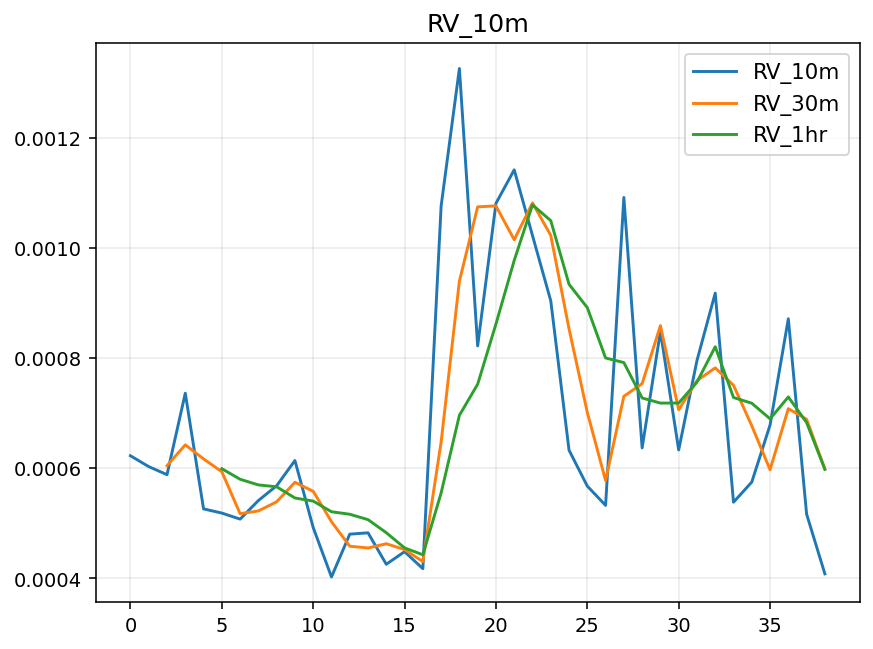

In [123]:
out['RV_10m'] = np.sqrt(out['TSRV'])
out['RV_10m'].plot(title='RV_10m')
out["t"] = out["window_end"]
rv = out["RV_10m"]
out["RV_30m"] = rv.rolling(window=3, min_periods=3).mean()
out["RV_1hr"] = rv.rolling(window=6, min_periods=6).mean()
rv_df = out[["t","RV_10m","RV_30m","RV_1hr"]]
rv_df['RV_30m'].plot(label='RV_30m')
rv_df['RV_1hr'].plot(label='RV_1hr').legend()
display(rv_df.head(10))

Saved: fig/rv_10m.png
       fig/rv_10m.pdf
Saved: fig/rv_30m_1h_EUR_USD.png
       fig/rv_30m_1h_EUR_USD.pdf


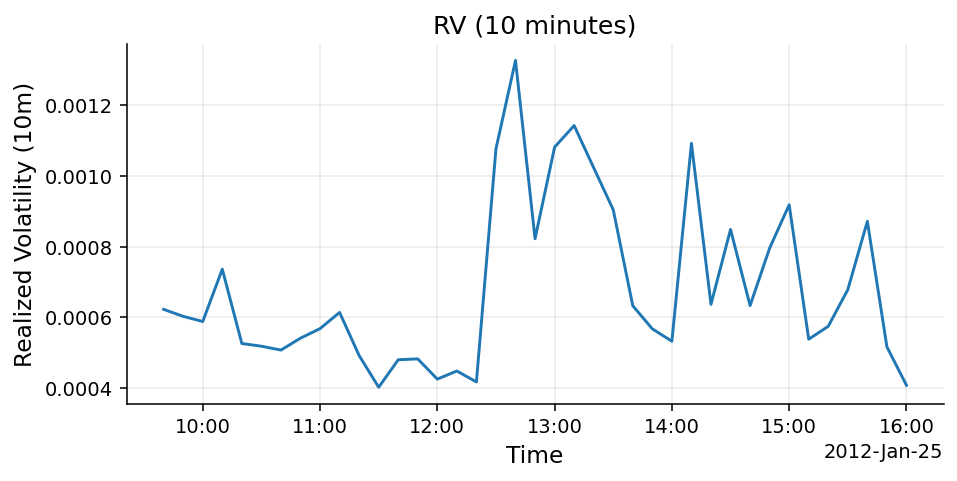

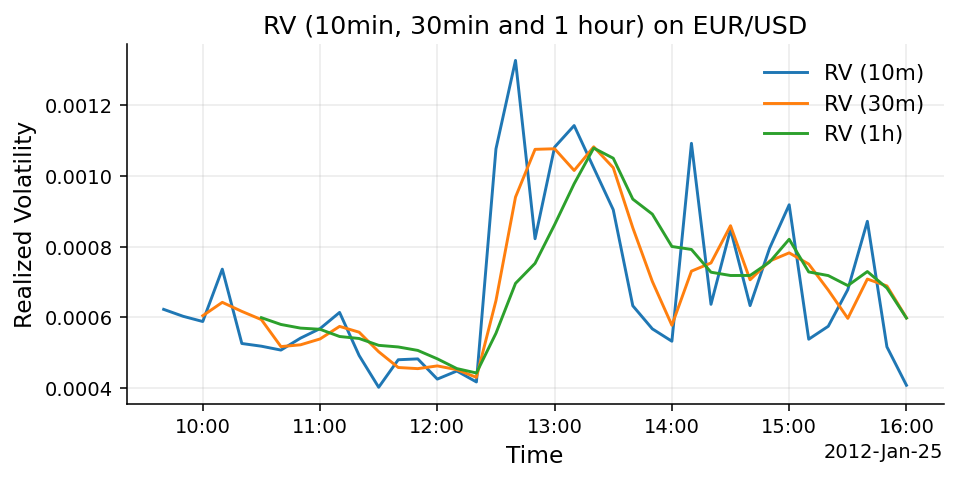

In [124]:
# DISCLAIMER:
# AI Generted Code for Plots 

# --- Pretty, publication-grade plots (matplotlib only) ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assumptions: rv_df has columns ["t","RV_10m","RV_30m","RV_1hr"]
rv_df = rv_df.sort_values("t").reset_index(drop=True).copy()

# Output dir
FIG_DIR = "fig"
os.makedirs(FIG_DIR, exist_ok=True)

# Global style (minimalist, no seaborn)
plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "figure.autolayout": True,   # tight layout
})

def setup_time_axis(ax):
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=8))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

def save_both(fig, basename):
    png_path = os.path.join(FIG_DIR, f"{basename}.png")
    pdf_path = os.path.join(FIG_DIR, f"{basename}.pdf")
    fig.savefig(png_path, bbox_inches="tight")
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"Saved: {png_path}\n       {pdf_path}")

# ------------- Figure 1: RV_10m -------------
fig1, ax1 = plt.subplots(figsize=(7.0, 3.6))
rv10 = rv_df[["t","RV_10m"]].dropna()
ax1.plot(rv10["t"], rv10["RV_10m"], linewidth=1.5)
ax1.set_title("RV (10 minutes)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Realized Volatility (10m)")
setup_time_axis(ax1)
save_both(fig1, "rv_10m")

# ------------- Figure 2: RV_30m vs RV_1hr -------------
fig2, ax2 = plt.subplots(figsize=(7.0, 3.6))
rv30 = rv_df[["t","RV_30m"]].dropna()
rv1h = rv_df[["t","RV_1hr"]].dropna()
ax2.plot(rv10["t"], rv10["RV_10m"], linewidth=1.5, label="RV (10m)")
ax2.plot(rv30["t"], rv30["RV_30m"], linewidth=1.5, label="RV (30m)")
ax2.plot(rv1h["t"], rv1h["RV_1hr"], linewidth=1.5, label="RV (1h)")
ax2.set_title("RV (10min, 30min and 1 hour) on EUR/USD")
ax2.set_xlabel("Time")
ax2.set_ylabel("Realized Volatility")
ax2.legend(frameon=False)
setup_time_axis(ax2)
save_both(fig2, "rv_30m_1h_EUR_USD")

plt.show()

## OLS and AR(6)

In [125]:
# Data preparation
df = rv_df.copy().sort_values("t").reset_index(drop=True)
df["y"] = df["RV_10m"].shift(-1)
# Features for OLS
X_mix = df[["RV_10m", "RV_30m", "RV_1hr"]]

# Features for AR(6)
for L in range(1, 7):
    df[f"RV_10m_lag{L}"] = df["RV_10m"].shift(L)
X_ar6 = df[[f"RV_10m_lag{L}" for L in range(1,7)]]

mix = pd.concat([df[["t","y"]], X_mix], axis=1).dropna()
ar6 = pd.concat([df[["t","y"]], X_ar6], axis=1).dropna()


def split_train_test(M):
    n = len(M)
    cut = int(np.floor(2*n/3))
    train = M.iloc[:cut].copy()
    test  = M.iloc[cut:].copy()
    return train, test

mix_tr, mix_te = split_train_test(mix)
ar6_tr, ar6_te = split_train_test(ar6)

In [126]:
# Helpers
def fit_ols(train_df, X_cols):
    X = sm.add_constant(train_df[X_cols].to_numpy())
    y = train_df["y"].to_numpy()
    model = sm.OLS(y, X).fit()
    return model

def predict(model, df_in, X_cols):
    X = sm.add_constant(df_in[X_cols].to_numpy(), has_constant="add")
    return pd.Series(model.predict(X), index=df_in.index)

def metrics(y_true, y_pred):
    e = y_pred - y_true
    mse = float(np.mean(e**2))
    mae = float(np.mean(np.abs(e)))
    # R^2 OOS (pseudo-R2) : 1 - SSE/SST (centré sur moyenne du test)
    sse = float(np.sum(e**2))
    sst = float(np.sum((y_true - np.mean(y_true))**2))
    r2  = 1.0 - sse/sst if sst > 0 else np.nan
    return {"MSE": mse, "MAE": mae, "R2": r2}

### OLS

In [127]:
mix_cols = ["RV_10m","RV_30m","RV_1hr"]
mix_model = fit_ols(mix_tr, mix_cols)

mix_tr_pred = predict(mix_model, mix_tr, mix_cols)
mix_te_pred = predict(mix_model, mix_te, mix_cols)

mix_tr_metrics = metrics(mix_tr["y"].to_numpy(), mix_tr_pred.to_numpy())
mix_te_metrics = metrics(mix_te["y"].to_numpy(), mix_te_pred.to_numpy())

print("\n=== MIX OLS: coefficients (c, beta_10m, beta_30m, beta_1h) ===")
print(mix_model.params)

print("OLS In-sample:", mix_tr_metrics)
print("OLS Out-of-sample:", mix_te_metrics)


=== MIX OLS: coefficients (c, beta_10m, beta_30m, beta_1h) ===
[ 2.91682978e-04  6.59398837e-01  5.89549880e-02 -1.08598537e-01]
OLS In-sample: {'MSE': 4.8304299870573806e-08, 'MAE': 0.0001670015740452904, 'R2': 0.3988101657364792}
OLS Out-of-sample: {'MSE': 4.330218000913325e-08, 'MAE': 0.00018436089289896985, 'R2': -0.7628016961730952}


### AR(6)

In [128]:
ar_cols = [f"RV_10m_lag{L}" for L in range(1,7)]
ar6_model = fit_ols(ar6_tr, ar_cols)

ar6_tr_pred = predict(ar6_model, ar6_tr, ar_cols)
ar6_te_pred = predict(ar6_model, ar6_te, ar_cols)

ar6_tr_metrics = metrics(ar6_tr["y"].to_numpy(), ar6_tr_pred.to_numpy())
ar6_te_metrics = metrics(ar6_te["y"].to_numpy(), ar6_te_pred.to_numpy())

print("\n=== AR(6) OLS: coefficients (c, phi1..phi6) ===")
print(ar6_model.params)

print("\nAR(6) In-sample:", ar6_tr_metrics)
print("AR(6) Out-of-sample:", ar6_te_metrics)


=== AR(6) OLS: coefficients (c, phi1..phi6) ===
[ 0.00061367  0.2518523   0.12225973  0.19043948 -0.02841159 -0.03655148
 -0.38287576]

AR(6) In-sample: {'MSE': 6.296155582809925e-08, 'MAE': 0.00018525914880115253, 'R2': 0.23375539955860125}
AR(6) Out-of-sample: {'MSE': 3.128355432883784e-08, 'MAE': 0.00014831203695244336, 'R2': -0.27353178573381376}


### Comparison

In [129]:
comp = pd.DataFrame({
    "model": ["OLS","AR6"],
    "MSE_oos": [mix_te_metrics["MSE"], ar6_te_metrics["MSE"]],
    "MAE_oos": [mix_te_metrics["MAE"], ar6_te_metrics["MAE"]],
    "R2_oos": [mix_te_metrics["R2"],  ar6_te_metrics["R2"]],
}).sort_values("MSE_oos")
print("\n=== OOS comparison (lower is better) ===")
print(comp.to_string(index=False))

pred_oos = pd.DataFrame({
    "t": mix_te["t"],
    "y_true": mix_te["y"],
    "y_pred_mix": mix_te_pred.reindex(mix_te.index),
}).merge(
    pd.DataFrame({"t": ar6_te["t"], "y_pred_ar6": ar6_te_pred.reindex(ar6_te.index)}),
    on="t", how="outer"
).sort_values("t").reset_index(drop=True)


=== OOS comparison (lower is better) ===
model      MSE_oos  MAE_oos    R2_oos
  AR6 3.128355e-08 0.000148 -0.273532
  OLS 4.330218e-08 0.000184 -0.762802


# EUR-JPY

In [130]:
pair = "EUR/JPY"

In [131]:
# Create L1 book
l1 = create_l1_from_orders(pair,orders_raw)
print(f"{pair} L1 Order Book:")
l1.dropna(inplace=True)
display(l1)

EUR/JPY L1 Order Book:


,ts,best_bid,best_ask,bid_depth,ask_depth,spread,rel_spread
9,2012-01-25 09:30:00.600000+00:00,101.240,101.264,2000000.0,1000000.0,0.024,0.000237
10,2012-01-25 09:30:00.700000+00:00,101.241,101.264,1000000.0,1000000.0,0.023,0.000227
11,2012-01-25 09:30:00.700000+00:00,101.241,101.264,1000000.0,1000000.0,0.023,0.000227
12,2012-01-25 09:30:00.700000+00:00,101.241,101.264,1000000.0,1000000.0,0.023,0.000227
13,2012-01-25 09:30:00.700000+00:00,101.241,101.264,1000000.0,1000000.0,0.023,0.000227
...,...,...,...,...,...,...,...
179438,2012-01-25 15:59:59.500000+00:00,101.928,101.949,1000000.0,1000000.0,0.021,0.000206
179439,2012-01-25 15:59:59.600000+00:00,101.928,101.949,1000000.0,2000000.0,0.021,0.000206
179440,2012-01-25 15:59:59.800000+00:00,101.928,101.948,1000000.0,1000000.0,0.020,0.000196
179441,2012-01-25 15:59:59.800000+00:00,101.928,101.948,1000000.0,1000000.0,0.020,0.000196


In [132]:
# Compute log prices for volatility analysis
vol = l1.copy()
vol['log_ask'] = np.log(vol['best_ask'])
vol['log_bid'] = np.log(vol['best_bid'])
vol['log_mid'] = 0.5*(vol['log_ask'] + vol['log_bid'])
display(vol)

,ts,best_bid,best_ask,bid_depth,ask_depth,spread,rel_spread,log_ask,log_bid,log_mid
9,2012-01-25 09:30:00.600000+00:00,101.240,101.264,2000000.0,1000000.0,0.024,0.000237,4.617731,4.617494,4.617612
10,2012-01-25 09:30:00.700000+00:00,101.241,101.264,1000000.0,1000000.0,0.023,0.000227,4.617731,4.617504,4.617617
11,2012-01-25 09:30:00.700000+00:00,101.241,101.264,1000000.0,1000000.0,0.023,0.000227,4.617731,4.617504,4.617617
12,2012-01-25 09:30:00.700000+00:00,101.241,101.264,1000000.0,1000000.0,0.023,0.000227,4.617731,4.617504,4.617617
13,2012-01-25 09:30:00.700000+00:00,101.241,101.264,1000000.0,1000000.0,0.023,0.000227,4.617731,4.617504,4.617617
...,...,...,...,...,...,...,...,...,...,...
179438,2012-01-25 15:59:59.500000+00:00,101.928,101.949,1000000.0,1000000.0,0.021,0.000206,4.624473,4.624267,4.624370
179439,2012-01-25 15:59:59.600000+00:00,101.928,101.949,1000000.0,2000000.0,0.021,0.000206,4.624473,4.624267,4.624370
179440,2012-01-25 15:59:59.800000+00:00,101.928,101.948,1000000.0,1000000.0,0.020,0.000196,4.624463,4.624267,4.624365
179441,2012-01-25 15:59:59.800000+00:00,101.928,101.948,1000000.0,1000000.0,0.020,0.000196,4.624463,4.624267,4.624365


## RV calculation

In [133]:
g = vol.groupby(pd.Grouper(key='ts', freq="10min", origin="start_day", label="left"))
out = []
K = 20
for win_start, gdf in g:
    if gdf.empty:
        continue
    X = gdf["log_mid"].to_numpy()
    n = len(X) - 1 
    if n <= 0 or n < K:  
        out.append({
            "window_start": win_start,
            "window_end": win_start + pd.Timedelta(minutes=10),
            "n": len(X), "K": K, "z": np.nan, "xxK": np.nan, "xxAll": np.nan, "TSRV": np.nan
        })
        continue
    d1 = X[1:] - X[:-1]
    xxAll = float(np.sum(d1 * d1)) 
   
    dK = X[K:] - X[:-K]                 
    xxK = float(np.sum(dK * dK) / K)    

    n_returns = len(d1)                
    z = (len(dK)) / K                   

    # TSRV_T^(10m) = (1 - z/n)^(-1) * ( [X,X]^K_T - (z/n) * [X,X]^All_T )
    fac = 1.0 - (z / n_returns)
    TSRV = np.nan if fac <= 0 else (xxK - (z / n_returns) * xxAll) / fac

    out.append({
        "window_start": win_start,
        "window_end": win_start + pd.Timedelta(minutes=10),
        "n": len(X), "K": K, "z": z, "xxK": xxK, "xxAll": xxAll, "TSRV": TSRV
    })
out = pd.DataFrame(out).sort_values("window_start").reset_index(drop=True)
display(out.head(10))

,window_start,window_end,n,K,z,xxK,xxAll,TSRV
0,2012-01-25 09:30:00+00:00,2012-01-25 09:40:00+00:00,6364,20,317.20,3.870958e-07,4.253996e-07,3.850862e-07
1,2012-01-25 09:40:00+00:00,2012-01-25 09:50:00+00:00,4970,20,247.50,2.923413e-07,2.749004e-07,2.932555e-07
2,2012-01-25 09:50:00+00:00,2012-01-25 10:00:00+00:00,5256,20,261.80,3.805000e-07,3.546030e-07,3.818578e-07
3,2012-01-25 10:00:00+00:00,2012-01-25 10:10:00+00:00,6544,20,326.20,5.346977e-07,4.674387e-07,5.382268e-07
4,2012-01-25 10:10:00+00:00,2012-01-25 10:20:00+00:00,4562,20,227.10,2.857193e-07,2.725897e-07,2.864073e-07
5,2012-01-25 10:20:00+00:00,2012-01-25 10:30:00+00:00,3650,20,181.50,2.143834e-07,1.915403e-07,2.155791e-07
6,2012-01-25 10:30:00+00:00,2012-01-25 10:40:00+00:00,4554,20,226.70,2.289090e-07,2.821090e-07,2.261213e-07
7,2012-01-25 10:40:00+00:00,2012-01-25 10:50:00+00:00,4064,20,202.20,3.072889e-07,2.742079e-07,3.090214e-07
8,2012-01-25 10:50:00+00:00,2012-01-25 11:00:00+00:00,4665,20,232.25,3.266005e-07,2.540948e-07,3.304003e-07
9,2012-01-25 11:00:00+00:00,2012-01-25 11:10:00+00:00,5168,20,257.40,2.772919e-07,2.752235e-07,2.774003e-07


,t,RV_10m,RV_30m,RV_1hr
0,2012-01-25 09:40:00+00:00,0.000621,NaN,NaN
1,2012-01-25 09:50:00+00:00,0.000542,NaN,NaN
2,2012-01-25 10:00:00+00:00,0.000618,0.000593,NaN
3,2012-01-25 10:10:00+00:00,0.000734,0.000631,NaN
4,2012-01-25 10:20:00+00:00,0.000535,0.000629,NaN
5,2012-01-25 10:30:00+00:00,0.000464,0.000578,0.000586
6,2012-01-25 10:40:00+00:00,0.000476,0.000492,0.000561
7,2012-01-25 10:50:00+00:00,0.000556,0.000499,0.000564
8,2012-01-25 11:00:00+00:00,0.000575,0.000535,0.000557
9,2012-01-25 11:10:00+00:00,0.000527,0.000552,0.000522


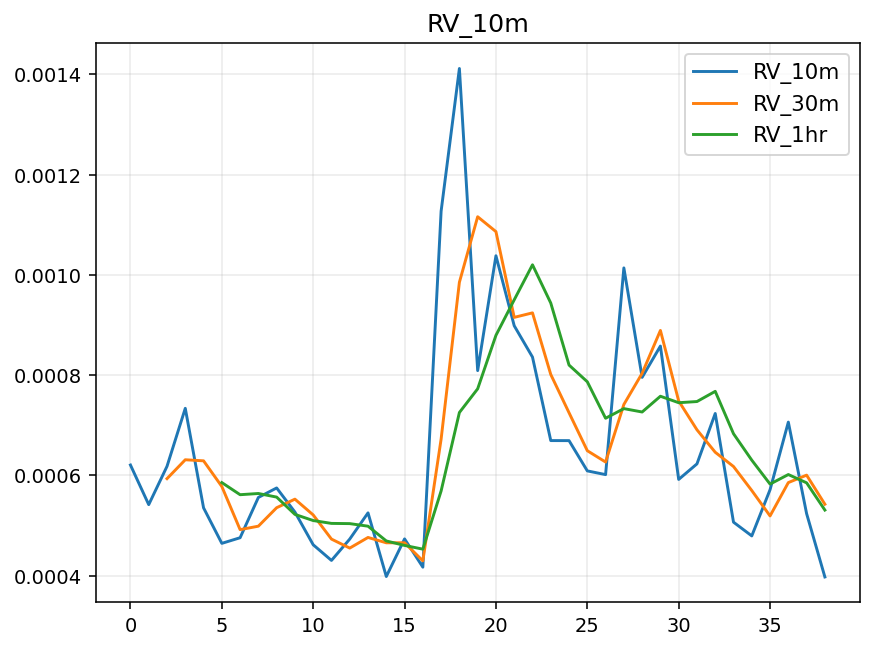

In [134]:
out['RV_10m'] = np.sqrt(out['TSRV'])
out['RV_10m'].plot(title='RV_10m')
out["t"] = out["window_end"]
rv = out["RV_10m"]
out["RV_30m"] = rv.rolling(window=3, min_periods=3).mean()
out["RV_1hr"] = rv.rolling(window=6, min_periods=6).mean()
rv_df = out[["t","RV_10m","RV_30m","RV_1hr"]]
rv_df['RV_30m'].plot(label='RV_30m')
rv_df['RV_1hr'].plot(label='RV_1hr').legend()
display(rv_df.head(10))

Saved: fig/rv_10m.png
       fig/rv_10m.pdf
Saved: fig/rv_30m_1h_EUR_JPY.png
       fig/rv_30m_1h_EUR_JPY.pdf


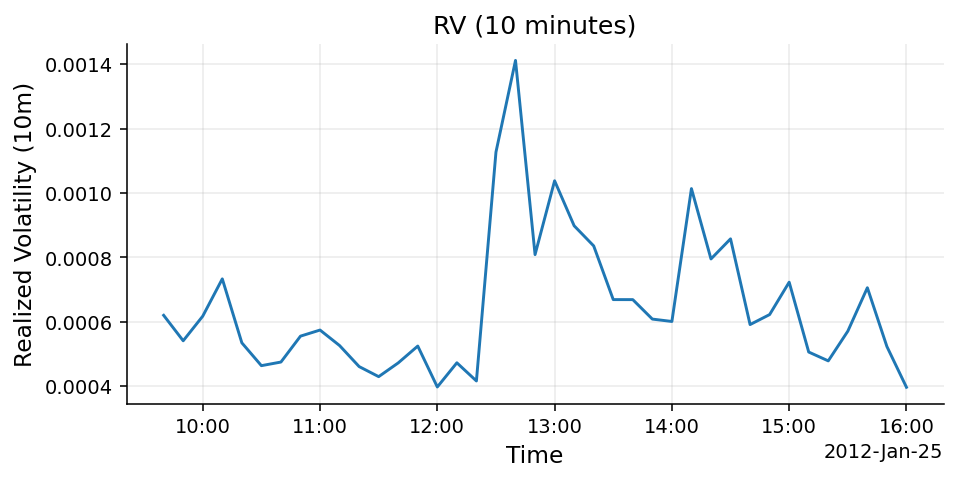

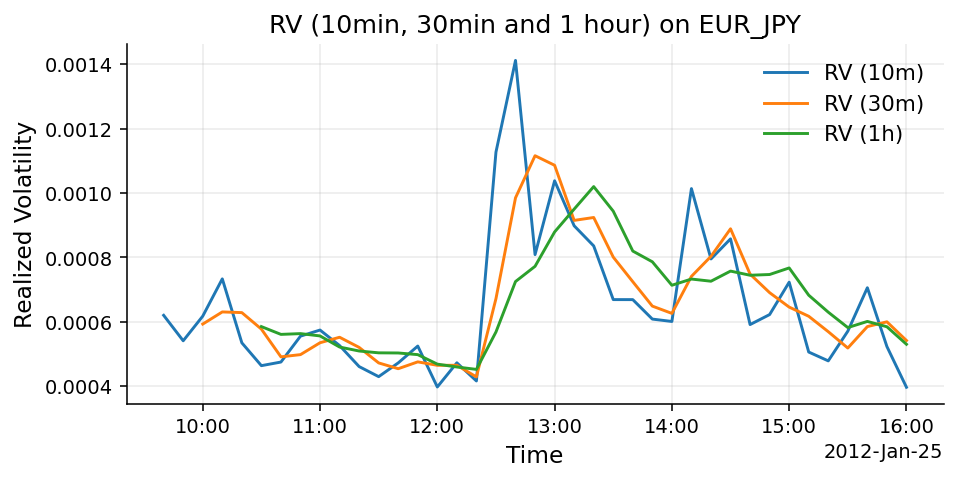

In [135]:
# DISCLAIMER:
# AI Generted Code for Plots 

# --- Pretty, publication-grade plots (matplotlib only) ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assumptions: rv_df has columns ["t","RV_10m","RV_30m","RV_1hr"]
rv_df = rv_df.sort_values("t").reset_index(drop=True).copy()

# Output dir
FIG_DIR = "fig"
os.makedirs(FIG_DIR, exist_ok=True)

# Global style (minimalist, no seaborn)
plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "figure.autolayout": True,   # tight layout
})

def setup_time_axis(ax):
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=8))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

def save_both(fig, basename):
    png_path = os.path.join(FIG_DIR, f"{basename}.png")
    pdf_path = os.path.join(FIG_DIR, f"{basename}.pdf")
    fig.savefig(png_path, bbox_inches="tight")
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"Saved: {png_path}\n       {pdf_path}")

# ------------- Figure 1: RV_10m -------------
fig1, ax1 = plt.subplots(figsize=(7.0, 3.6))
rv10 = rv_df[["t","RV_10m"]].dropna()
ax1.plot(rv10["t"], rv10["RV_10m"], linewidth=1.5)
ax1.set_title("RV (10 minutes)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Realized Volatility (10m)")
setup_time_axis(ax1)
save_both(fig1, "rv_10m")

# ------------- Figure 2: RV_30m vs RV_1hr -------------
fig2, ax2 = plt.subplots(figsize=(7.0, 3.6))
rv30 = rv_df[["t","RV_30m"]].dropna()
rv1h = rv_df[["t","RV_1hr"]].dropna()
ax2.plot(rv10["t"], rv10["RV_10m"], linewidth=1.5, label="RV (10m)")
ax2.plot(rv30["t"], rv30["RV_30m"], linewidth=1.5, label="RV (30m)")
ax2.plot(rv1h["t"], rv1h["RV_1hr"], linewidth=1.5, label="RV (1h)")
ax2.set_title("RV (10min, 30min and 1 hour) on EUR_JPY")
ax2.set_xlabel("Time")
ax2.set_ylabel("Realized Volatility")
ax2.legend(frameon=False)
setup_time_axis(ax2)
save_both(fig2, "rv_30m_1h_EUR_JPY")

plt.show()

## OLS and AR(6)

In [136]:
# Data preparation
df = rv_df.copy().sort_values("t").reset_index(drop=True)
df["y"] = df["RV_10m"].shift(-1)
# Features for OLS
X_mix = df[["RV_10m", "RV_30m", "RV_1hr"]]

# Features for AR(6)
for L in range(1, 7):
    df[f"RV_10m_lag{L}"] = df["RV_10m"].shift(L)
X_ar6 = df[[f"RV_10m_lag{L}" for L in range(1,7)]]

mix = pd.concat([df[["t","y"]], X_mix], axis=1).dropna()
ar6 = pd.concat([df[["t","y"]], X_ar6], axis=1).dropna()


def split_train_test(M):
    n = len(M)
    cut = int(np.floor(2*n/3))
    train = M.iloc[:cut].copy()
    test = M.iloc[cut:].copy()
    return train, test

mix_tr, mix_te = split_train_test(mix)
ar6_tr, ar6_te = split_train_test(ar6)

In [137]:
# Helpers
def fit_ols(train_df, X_cols):
    X = sm.add_constant(train_df[X_cols].to_numpy())
    y = train_df["y"].to_numpy()
    model = sm.OLS(y, X).fit()
    return model

def predict(model, df_in, X_cols):
    X = sm.add_constant(df_in[X_cols].to_numpy(), has_constant="add")
    return pd.Series(model.predict(X), index=df_in.index)

def metrics(y_true, y_pred):
    e = y_pred - y_true
    mse = float(np.mean(e**2))
    mae = float(np.mean(np.abs(e)))
    # R^2 OOS (pseudo-R2) : 1 - SSE/SST (centré sur moyenne du test)
    sse = float(np.sum(e**2))
    sst = float(np.sum((y_true - np.mean(y_true))**2))
    r2  = 1.0 - sse/sst if sst > 0 else np.nan
    return {"MSE": mse, "MAE": mae, "R2": r2}

### OLS

In [138]:
mix_cols = ["RV_10m","RV_30m","RV_1hr"]
mix_model = fit_ols(mix_tr, mix_cols)

mix_tr_pred = predict(mix_model, mix_tr, mix_cols)
mix_te_pred = predict(mix_model, mix_te, mix_cols)

mix_tr_metrics = metrics(mix_tr["y"].to_numpy(), mix_tr_pred.to_numpy())
mix_te_metrics = metrics(mix_te["y"].to_numpy(), mix_te_pred.to_numpy())

print("\n=== MIX OLS: coefficients (c, beta_10m, beta_30m, beta_1h) ===")
print(mix_model.params)

print("OLS In-sample:", mix_tr_metrics)
print("OLS Out-of-sample:", mix_te_metrics)


=== MIX OLS: coefficients (c, beta_10m, beta_30m, beta_1h) ===
[ 3.36976876e-04  5.55860466e-01  1.89826812e-01 -2.22060435e-01]
OLS In-sample: {'MSE': 4.580413689496373e-08, 'MAE': 0.00015197845957052992, 'R2': 0.3433986975708957}
OLS Out-of-sample: {'MSE': 1.8341485790507743e-08, 'MAE': 0.00011437280801953261, 'R2': -0.008676382516939585}


### AR(6)

In [139]:
ar_cols = [f"RV_10m_lag{L}" for L in range(1,7)]
ar6_model = fit_ols(ar6_tr, ar_cols)

ar6_tr_pred = predict(ar6_model, ar6_tr, ar_cols)
ar6_te_pred = predict(ar6_model, ar6_te, ar_cols)

ar6_tr_metrics = metrics(ar6_tr["y"].to_numpy(), ar6_tr_pred.to_numpy())
ar6_te_metrics = metrics(ar6_te["y"].to_numpy(), ar6_te_pred.to_numpy())

print("\n=== AR(6) OLS: coefficients (c, phi1..phi6) ===")
print(ar6_model.params)

print("\nAR(6) In-sample:", ar6_tr_metrics)
print("AR(6) Out-of-sample:", ar6_te_metrics)


=== AR(6) OLS: coefficients (c, phi1..phi6) ===
[ 0.00055782  0.25673878  0.1597405  -0.07872243  0.05802599 -0.16588864
 -0.0320452 ]

AR(6) In-sample: {'MSE': 6.132227750850422e-08, 'MAE': 0.00017133028690988856, 'R2': 0.13587874098373032}
AR(6) Out-of-sample: {'MSE': 2.2337892650081965e-08, 'MAE': 0.0001293427555831427, 'R2': -0.22845580825285317}


### Comparison

In [140]:
comp = pd.DataFrame({
    "model": ["OLS","AR6"],
    "MSE_oos": [mix_te_metrics["MSE"], ar6_te_metrics["MSE"]],
    "MAE_oos": [mix_te_metrics["MAE"], ar6_te_metrics["MAE"]],
    "R2_oos": [mix_te_metrics["R2"],  ar6_te_metrics["R2"]],
}).sort_values("MSE_oos")
print("\n=== OOS comparison (lower is better) ===")
print(comp.to_string(index=False))

pred_oos = pd.DataFrame({
    "t": mix_te["t"],
    "y_true": mix_te["y"],
    "y_pred_mix": mix_te_pred.reindex(mix_te.index),
}).merge(
    pd.DataFrame({"t": ar6_te["t"], "y_pred_ar6": ar6_te_pred.reindex(ar6_te.index)}),
    on="t", how="outer"
).sort_values("t").reset_index(drop=True)


=== OOS comparison (lower is better) ===
model      MSE_oos  MAE_oos    R2_oos
  OLS 1.834149e-08 0.000114 -0.008676
  AR6 2.233789e-08 0.000129 -0.228456


# USD-JPY

In [141]:
pair = "USD/JPY"

In [142]:
# Create L1 book
l1 = create_l1_from_orders(pair,orders_raw)
print(f"{pair} L1 Order Book:")
l1.dropna(inplace=True)
display(l1)

USD/JPY L1 Order Book:


,ts,best_bid,best_ask,bid_depth,ask_depth,spread,rel_spread
7,2012-01-25 09:30:00.500000+00:00,78.053,78.076,2000000.0,2000000.0,0.023,0.000295
8,2012-01-25 09:30:00.600000+00:00,78.053,78.065,2000000.0,2000000.0,0.012,0.000154
9,2012-01-25 09:30:00.600000+00:00,78.053,78.065,2000000.0,2000000.0,0.012,0.000154
10,2012-01-25 09:30:00.800000+00:00,78.052,78.065,4000000.0,2000000.0,0.013,0.000167
11,2012-01-25 09:30:00.800000+00:00,78.052,78.065,1000000.0,2000000.0,0.013,0.000167
...,...,...,...,...,...,...,...
179277,2012-01-25 15:59:58+00:00,77.736,77.738,1000000.0,1000000.0,0.002,0.000026
179278,2012-01-25 15:59:58.300000+00:00,77.736,77.738,1000000.0,1000000.0,0.002,0.000026
179279,2012-01-25 15:59:58.300000+00:00,77.736,77.738,1000000.0,1000000.0,0.002,0.000026
179280,2012-01-25 15:59:59.300000+00:00,77.736,77.738,1000000.0,1000000.0,0.002,0.000026


In [143]:
# Compute log prices for volatility analysis
vol = l1.copy()
vol['log_ask'] = np.log(vol['best_ask'])
vol['log_bid'] = np.log(vol['best_bid'])
vol['log_mid'] = 0.5*(vol['log_ask'] + vol['log_bid'])
display(vol)

,ts,best_bid,best_ask,bid_depth,ask_depth,spread,rel_spread,log_ask,log_bid,log_mid
7,2012-01-25 09:30:00.500000+00:00,78.053,78.076,2000000.0,2000000.0,0.023,0.000295,4.357683,4.357388,4.357535
8,2012-01-25 09:30:00.600000+00:00,78.053,78.065,2000000.0,2000000.0,0.012,0.000154,4.357542,4.357388,4.357465
9,2012-01-25 09:30:00.600000+00:00,78.053,78.065,2000000.0,2000000.0,0.012,0.000154,4.357542,4.357388,4.357465
10,2012-01-25 09:30:00.800000+00:00,78.052,78.065,4000000.0,2000000.0,0.013,0.000167,4.357542,4.357375,4.357459
11,2012-01-25 09:30:00.800000+00:00,78.052,78.065,1000000.0,2000000.0,0.013,0.000167,4.357542,4.357375,4.357459
...,...,...,...,...,...,...,...,...,...,...
179277,2012-01-25 15:59:58+00:00,77.736,77.738,1000000.0,1000000.0,0.002,0.000026,4.353344,4.353318,4.353331
179278,2012-01-25 15:59:58.300000+00:00,77.736,77.738,1000000.0,1000000.0,0.002,0.000026,4.353344,4.353318,4.353331
179279,2012-01-25 15:59:58.300000+00:00,77.736,77.738,1000000.0,1000000.0,0.002,0.000026,4.353344,4.353318,4.353331
179280,2012-01-25 15:59:59.300000+00:00,77.736,77.738,1000000.0,1000000.0,0.002,0.000026,4.353344,4.353318,4.353331


## RV calculation

In [144]:
g = vol.groupby(pd.Grouper(key='ts', freq="10min", origin="start_day", label="left"))
out = []
K = 20
for win_start, gdf in g:
    if gdf.empty:
        continue
    X = gdf["log_mid"].to_numpy()
    n = len(X) - 1 
    if n <= 0 or n < K:  
        out.append({
            "window_start": win_start,
            "window_end": win_start + pd.Timedelta(minutes=10),
            "n": len(X), "K": K, "z": np.nan, "xxK": np.nan, "xxAll": np.nan, "TSRV": np.nan
        })
        continue
    d1 = X[1:] - X[:-1]
    xxAll = float(np.sum(d1 * d1)) 
   
    dK = X[K:] - X[:-K]                 
    xxK = float(np.sum(dK * dK) / K)    

    n_returns = len(d1)                
    z = (len(dK)) / K                   

    # TSRV_T^(10m) = (1 - z/n)^(-1) * ( [X,X]^K_T - (z/n) * [X,X]^All_T )
    fac = 1.0 - (z / n_returns)
    TSRV = np.nan if fac <= 0 else (xxK - (z / n_returns) * xxAll) / fac

    out.append({
        "window_start": win_start,
        "window_end": win_start + pd.Timedelta(minutes=10),
        "n": len(X), "K": K, "z": z, "xxK": xxK, "xxAll": xxAll, "TSRV": TSRV
    })
out = pd.DataFrame(out).sort_values("window_start").reset_index(drop=True)
display(out.head(10))

,window_start,window_end,n,K,z,xxK,xxAll,TSRV
0,2012-01-25 09:30:00+00:00,2012-01-25 09:40:00+00:00,4305,20,214.25,2.099164e-07,2.287201e-07,2.089314e-07
1,2012-01-25 09:40:00+00:00,2012-01-25 09:50:00+00:00,3592,20,178.60,1.931048e-07,2.035204e-07,1.925597e-07
2,2012-01-25 09:50:00+00:00,2012-01-25 10:00:00+00:00,4942,20,246.10,3.301624e-07,3.401187e-07,3.296405e-07
3,2012-01-25 10:00:00+00:00,2012-01-25 10:10:00+00:00,4206,20,209.30,2.864254e-07,3.610013e-07,2.825191e-07
4,2012-01-25 10:10:00+00:00,2012-01-25 10:20:00+00:00,2907,20,144.35,9.042465e-08,9.544706e-08,9.016213e-08
5,2012-01-25 10:20:00+00:00,2012-01-25 10:30:00+00:00,2717,20,134.85,6.098136e-08,8.277405e-08,5.984282e-08
6,2012-01-25 10:30:00+00:00,2012-01-25 10:40:00+00:00,5736,20,285.80,2.031989e-07,2.637255e-07,2.000244e-07
7,2012-01-25 10:40:00+00:00,2012-01-25 10:50:00+00:00,4128,20,205.40,1.507107e-07,1.849379e-07,1.489180e-07
8,2012-01-25 10:50:00+00:00,2012-01-25 11:00:00+00:00,4773,20,237.65,2.626276e-07,3.363116e-07,2.587657e-07
9,2012-01-25 11:00:00+00:00,2012-01-25 11:10:00+00:00,4589,20,228.45,1.653718e-07,1.868198e-07,1.642479e-07


,t,RV_10m,RV_30m,RV_1hr
0,2012-01-25 09:40:00+00:00,0.000457,NaN,NaN
1,2012-01-25 09:50:00+00:00,0.000439,NaN,NaN
2,2012-01-25 10:00:00+00:00,0.000574,0.000490,NaN
3,2012-01-25 10:10:00+00:00,0.000532,0.000515,NaN
4,2012-01-25 10:20:00+00:00,0.000300,0.000469,NaN
5,2012-01-25 10:30:00+00:00,0.000245,0.000359,0.000424
6,2012-01-25 10:40:00+00:00,0.000447,0.000331,0.000423
7,2012-01-25 10:50:00+00:00,0.000386,0.000359,0.000414
8,2012-01-25 11:00:00+00:00,0.000509,0.000447,0.000403
9,2012-01-25 11:10:00+00:00,0.000405,0.000433,0.000382


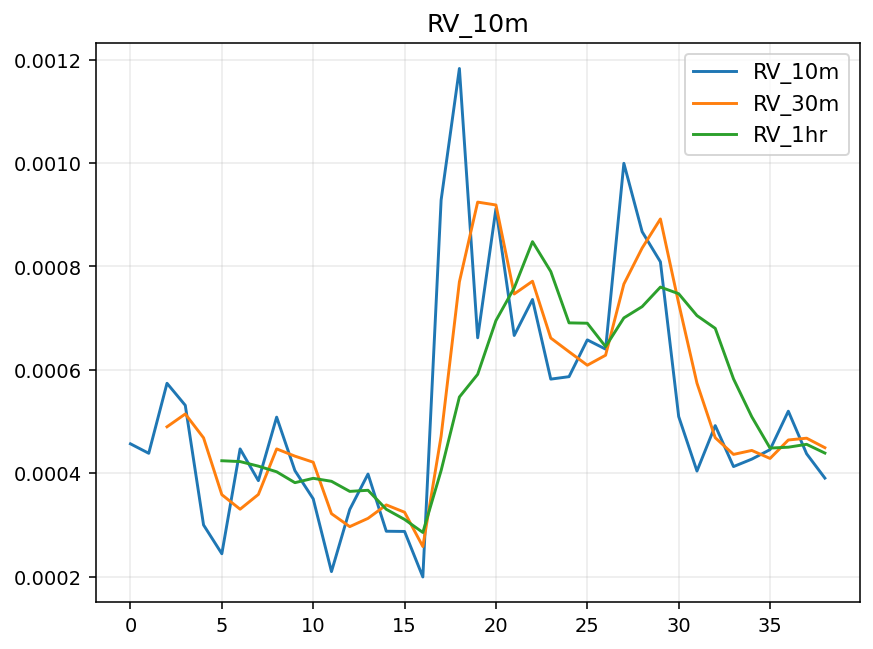

In [145]:
out['RV_10m'] = np.sqrt(out['TSRV'])
out['RV_10m'].plot(title='RV_10m')
out["t"] = out["window_end"]
rv = out["RV_10m"]
out["RV_30m"] = rv.rolling(window=3, min_periods=3).mean()
out["RV_1hr"] = rv.rolling(window=6, min_periods=6).mean()
rv_df = out[["t","RV_10m","RV_30m","RV_1hr"]]
rv_df['RV_30m'].plot(label='RV_30m')
rv_df['RV_1hr'].plot(label='RV_1hr').legend()
display(rv_df.head(10))

Saved: fig/rv_10m.png
       fig/rv_10m.pdf
Saved: fig/rv_30m_1h_USD_JPY.png
       fig/rv_30m_1h_USD_JPY.pdf


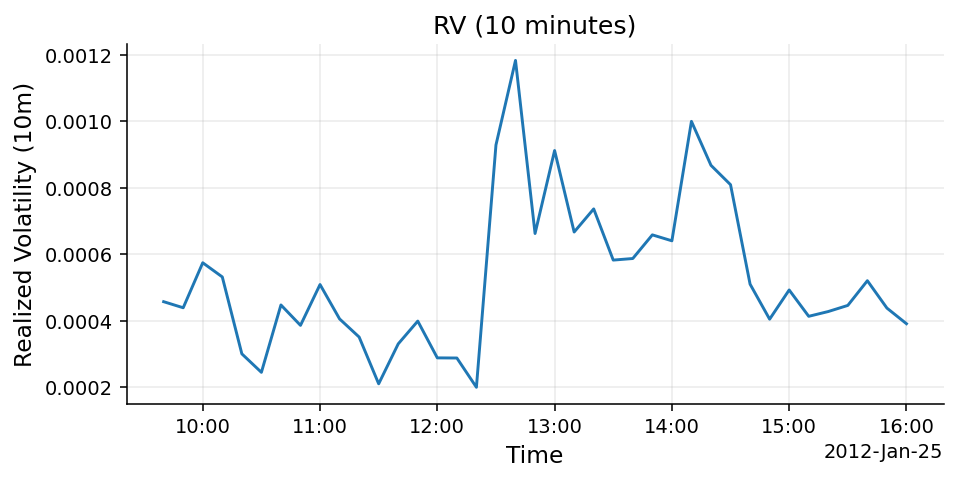

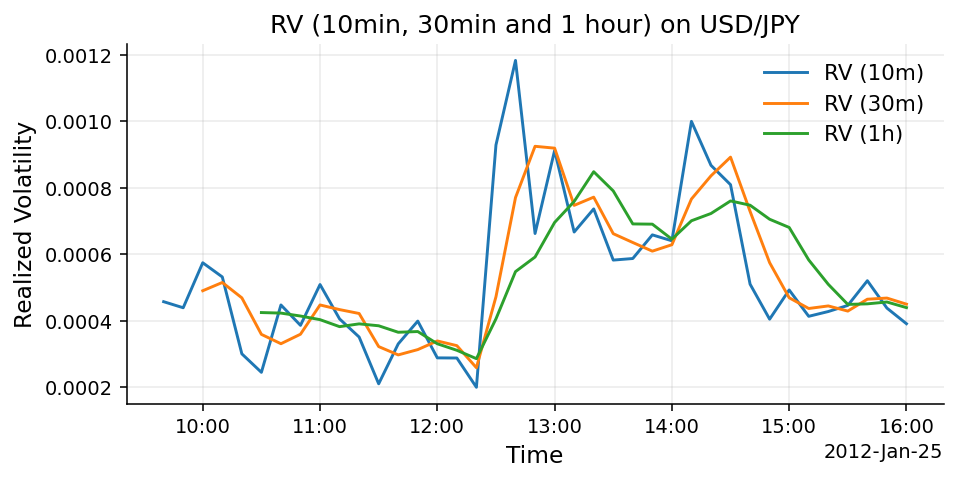

In [146]:
# DISCLAIMER:
# AI Generted Code for Plots 

# --- Pretty, publication-grade plots (matplotlib only) ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assumptions: rv_df has columns ["t","RV_10m","RV_30m","RV_1hr"]
rv_df = rv_df.sort_values("t").reset_index(drop=True).copy()

# Output dir
FIG_DIR = "fig"
os.makedirs(FIG_DIR, exist_ok=True)

# Global style (minimalist, no seaborn)
plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "figure.autolayout": True,   # tight layout
})

def setup_time_axis(ax):
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=8))
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

def save_both(fig, basename):
    png_path = os.path.join(FIG_DIR, f"{basename}.png")
    pdf_path = os.path.join(FIG_DIR, f"{basename}.pdf")
    fig.savefig(png_path, bbox_inches="tight")
    fig.savefig(pdf_path, bbox_inches="tight")
    print(f"Saved: {png_path}\n       {pdf_path}")

# ------------- Figure 1: RV_10m -------------
fig1, ax1 = plt.subplots(figsize=(7.0, 3.6))
rv10 = rv_df[["t","RV_10m"]].dropna()
ax1.plot(rv10["t"], rv10["RV_10m"], linewidth=1.5)
ax1.set_title("RV (10 minutes)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Realized Volatility (10m)")
setup_time_axis(ax1)
save_both(fig1, "rv_10m")

# ------------- Figure 2: RV_30m vs RV_1hr -------------
fig2, ax2 = plt.subplots(figsize=(7.0, 3.6))
rv30 = rv_df[["t","RV_30m"]].dropna()
rv1h = rv_df[["t","RV_1hr"]].dropna()
ax2.plot(rv10["t"], rv10["RV_10m"], linewidth=1.5, label="RV (10m)")
ax2.plot(rv30["t"], rv30["RV_30m"], linewidth=1.5, label="RV (30m)")
ax2.plot(rv1h["t"], rv1h["RV_1hr"], linewidth=1.5, label="RV (1h)")
ax2.set_title("RV (10min, 30min and 1 hour) on USD/JPY")
ax2.set_xlabel("Time")
ax2.set_ylabel("Realized Volatility")
ax2.legend(frameon=False)
setup_time_axis(ax2)
save_both(fig2, "rv_30m_1h_USD_JPY")

plt.show()

## OLS and AR(6)

In [147]:
# Data preparation
df = rv_df.copy().sort_values("t").reset_index(drop=True)
df["y"] = df["RV_10m"].shift(-1)
# Features for OLS
X_mix = df[["RV_10m", "RV_30m", "RV_1hr"]]

# Features for AR(6)
for L in range(1, 7):
    df[f"RV_10m_lag{L}"] = df["RV_10m"].shift(L)
X_ar6 = df[[f"RV_10m_lag{L}" for L in range(1,7)]]

mix = pd.concat([df[["t","y"]], X_mix], axis=1).dropna()
ar6 = pd.concat([df[["t","y"]], X_ar6], axis=1).dropna()


def split_train_test(M):
    n = len(M)
    cut = int(np.floor(2*n/3))
    train = M.iloc[:cut].copy()
    test  = M.iloc[cut:].copy()
    return train, test

mix_tr, mix_te = split_train_test(mix)
ar6_tr, ar6_te = split_train_test(ar6)

In [148]:
# Helpers
def fit_ols(train_df, X_cols):
    X = sm.add_constant(train_df[X_cols].to_numpy())
    y = train_df["y"].to_numpy()
    model = sm.OLS(y, X).fit()
    return model

def predict(model, df_in, X_cols):
    X = sm.add_constant(df_in[X_cols].to_numpy(), has_constant="add")
    return pd.Series(model.predict(X), index=df_in.index)

def metrics(y_true, y_pred):
    e = y_pred - y_true
    mse = float(np.mean(e**2))
    mae = float(np.mean(np.abs(e)))
    # R^2 OOS (pseudo-R2) : 1 - SSE/SST (centré sur moyenne du test)
    sse = float(np.sum(e**2))
    sst = float(np.sum((y_true - np.mean(y_true))**2))
    r2  = 1.0 - sse/sst if sst > 0 else np.nan
    return {"MSE": mse, "MAE": mae, "R2": r2}

### OLS

In [149]:
mix_cols = ["RV_10m","RV_30m","RV_1hr"]
mix_model = fit_ols(mix_tr, mix_cols)

mix_tr_pred = predict(mix_model, mix_tr, mix_cols)
mix_te_pred = predict(mix_model, mix_te, mix_cols)

mix_tr_metrics = metrics(mix_tr["y"].to_numpy(), mix_tr_pred.to_numpy())
mix_te_metrics = metrics(mix_te["y"].to_numpy(), mix_te_pred.to_numpy())

print("\n=== MIX OLS: coefficients (c, beta_10m, beta_30m, beta_1h) ===")
print(mix_model.params)

print("OLS In-sample:", mix_tr_metrics)
print("OLS Out-of-sample:", mix_te_metrics)


=== MIX OLS: coefficients (c, beta_10m, beta_30m, beta_1h) ===
[2.21363402e-04 4.95141381e-01 1.24602092e-01 2.99551064e-02]
OLS In-sample: {'MSE': 4.614834775531063e-08, 'MAE': 0.00016296780848166877, 'R2': 0.3243573773630256}
OLS Out-of-sample: {'MSE': 1.3538484987511726e-08, 'MAE': 9.265884034583092e-05, 'R2': 0.4425036253938295}


### AR(6)

In [150]:
ar_cols = [f"RV_10m_lag{L}" for L in range(1,7)]
ar6_model = fit_ols(ar6_tr, ar_cols)

ar6_tr_pred = predict(ar6_model, ar6_tr, ar_cols)
ar6_te_pred = predict(ar6_model, ar6_te, ar_cols)

ar6_tr_metrics = metrics(ar6_tr["y"].to_numpy(), ar6_tr_pred.to_numpy())
ar6_te_metrics = metrics(ar6_te["y"].to_numpy(), ar6_te_pred.to_numpy())

print("\n=== AR(6) OLS: coefficients (c, phi1..phi6) ===")
print(ar6_model.params)

print("\nAR(6) In-sample:", ar6_tr_metrics)
print("AR(6) Out-of-sample:", ar6_te_metrics)


=== AR(6) OLS: coefficients (c, phi1..phi6) ===
[ 0.0003329   0.32826952  0.07183458 -0.06061728  0.23034566 -0.20991424
  0.09224021]

AR(6) In-sample: {'MSE': 5.8690374813231944e-08, 'MAE': 0.00017299659253348733, 'R2': 0.17217358357276336}
AR(6) Out-of-sample: {'MSE': 2.7091153150051595e-08, 'MAE': 0.00014368247635504266, 'R2': -0.11557679304485924}


### Comparison

In [151]:
comp = pd.DataFrame({
    "model": ["OLS","AR6"],
    "MSE_oos": [mix_te_metrics["MSE"], ar6_te_metrics["MSE"]],
    "MAE_oos": [mix_te_metrics["MAE"], ar6_te_metrics["MAE"]],
    "R2_oos": [mix_te_metrics["R2"],  ar6_te_metrics["R2"]],
}).sort_values("MSE_oos")
print("\n=== OOS comparison (lower is better) ===")
print(comp.to_string(index=False))

pred_oos = pd.DataFrame({
    "t": mix_te["t"],
    "y_true": mix_te["y"],
    "y_pred_mix": mix_te_pred.reindex(mix_te.index),
}).merge(
    pd.DataFrame({"t": ar6_te["t"], "y_pred_ar6": ar6_te_pred.reindex(ar6_te.index)}),
    on="t", how="outer"
).sort_values("t").reset_index(drop=True)


=== OOS comparison (lower is better) ===
model      MSE_oos  MAE_oos    R2_oos
  OLS 1.353848e-08 0.000093  0.442504
  AR6 2.709115e-08 0.000144 -0.115577
